Результаты прогноза на нерегулярных временных рядах с фичами по дате.

## Imports

In [1]:
import sys
import os
import warnings
import json
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from gluonts.dataset.repository.datasets import dataset_recipes, get_dataset

sys.path.append('../')

/var/folders/9z/qk2z_2yx52x3vny8hmx1wj2c0000gp/T/ipykernel_75195/3279485910.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/Users/eliseev_s/anaconda3/envs/env1/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/Users/eliseev_s/anaconda3/envs/env1/lib/python3.9/site-packages/gluonts/dataset/artificial/_base.py:84: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  self.freq: BaseOffset = t

In [2]:
warnings.filterwarnings('ignore')

## Read Datasets

### Initital datasets

In [3]:
exchange = get_dataset("exchange_rate", regenerate=False)

solar = get_dataset("solar_nips", regenerate=False)

electricity = get_dataset("electricity_nips", regenerate=False)

### Targets/forecasts

In [4]:
MAF_PATH = "../trans_maf/notebooks/reports/maf/run_03/predictions"

DATASETS = ["solar", "electricity", "exchange"]

### Metrics

In [5]:
models = []
metrics = []
metrics_names = []
datasets = []
probabilities = []

for model_path, model_name in zip([MAF_PATH], ['trans_maf']):
    for dataset in DATASETS:
        for nans_prob in np.linspace(0.0, 0.8, 9):
            nans_prob = np.round(nans_prob, 1)
            
            try:
                with open(os.path.join(model_path, f'agg_metrics__{dataset}_{nans_prob}.json')) as f:
                    data = json.load(f)

                    for metric in ["MAPE", "RMSE", "m_sum_mean_wQuantileLoss"]:
                        models.append(model_name)
                        metrics.append(data[metric])
                        metrics_names.append(metric)
                        datasets.append(dataset)
                        probabilities.append(nans_prob)

            except:
                print(f"No data for {dataset} with nans prob = {nans_prob}")

metrics_df = pd.DataFrame({
    "model": models, 
    "metric": metrics,
    "metric_name": metrics_names,
    "dataset": datasets,
    "nans_prob": probabilities
})

metrics_df["metric_name"] = metrics_df["metric_name"].replace({
    "m_sum_mean_wQuantileLoss": "CRPS_sum"
})

No data for solar with nans prob = 0.8
No data for electricity with nans prob = 0.1
No data for electricity with nans prob = 0.7
No data for electricity with nans prob = 0.8


### Predictions

In [6]:
forecasts = {}

for model_path, model_name in zip([MAF_PATH], ['trans_maf']):

    forecasts[model_name] = {}
    
    for dataset in DATASETS:
        forecasts[model_name][dataset] = {}

        for nans_prob in np.linspace(0, 0.8, 9):
            nans_prob = np.round(nans_prob, 1)

            forecasts[model_name][dataset][nans_prob] = {}
    
            for ts in ["targets", "forecasts"]:
                
                try:
                    with open(os.path.join(model_path, f'{ts}__{dataset}_{nans_prob}.json'), "rb") as fp:
                        data = pickle.load(fp)

                    forecasts[model_name][dataset][nans_prob][ts] = data
                except:
                    print(f"No data for {dataset} {ts} with nans prob = {nans_prob}")

No data for solar targets with nans prob = 0.8
No data for solar forecasts with nans prob = 0.8
No data for electricity targets with nans prob = 0.1
No data for electricity forecasts with nans prob = 0.1
No data for electricity targets with nans prob = 0.7
No data for electricity forecasts with nans prob = 0.7
No data for electricity targets with nans prob = 0.8
No data for electricity forecasts with nans prob = 0.8


## Metrics visualisation

In [7]:
all_metrics = {}

for metric in ["MAPE", "RMSE", "CRPS_sum"]:
    all_metrics[metric] = metrics_df[metrics_df["metric_name"] == metric] 

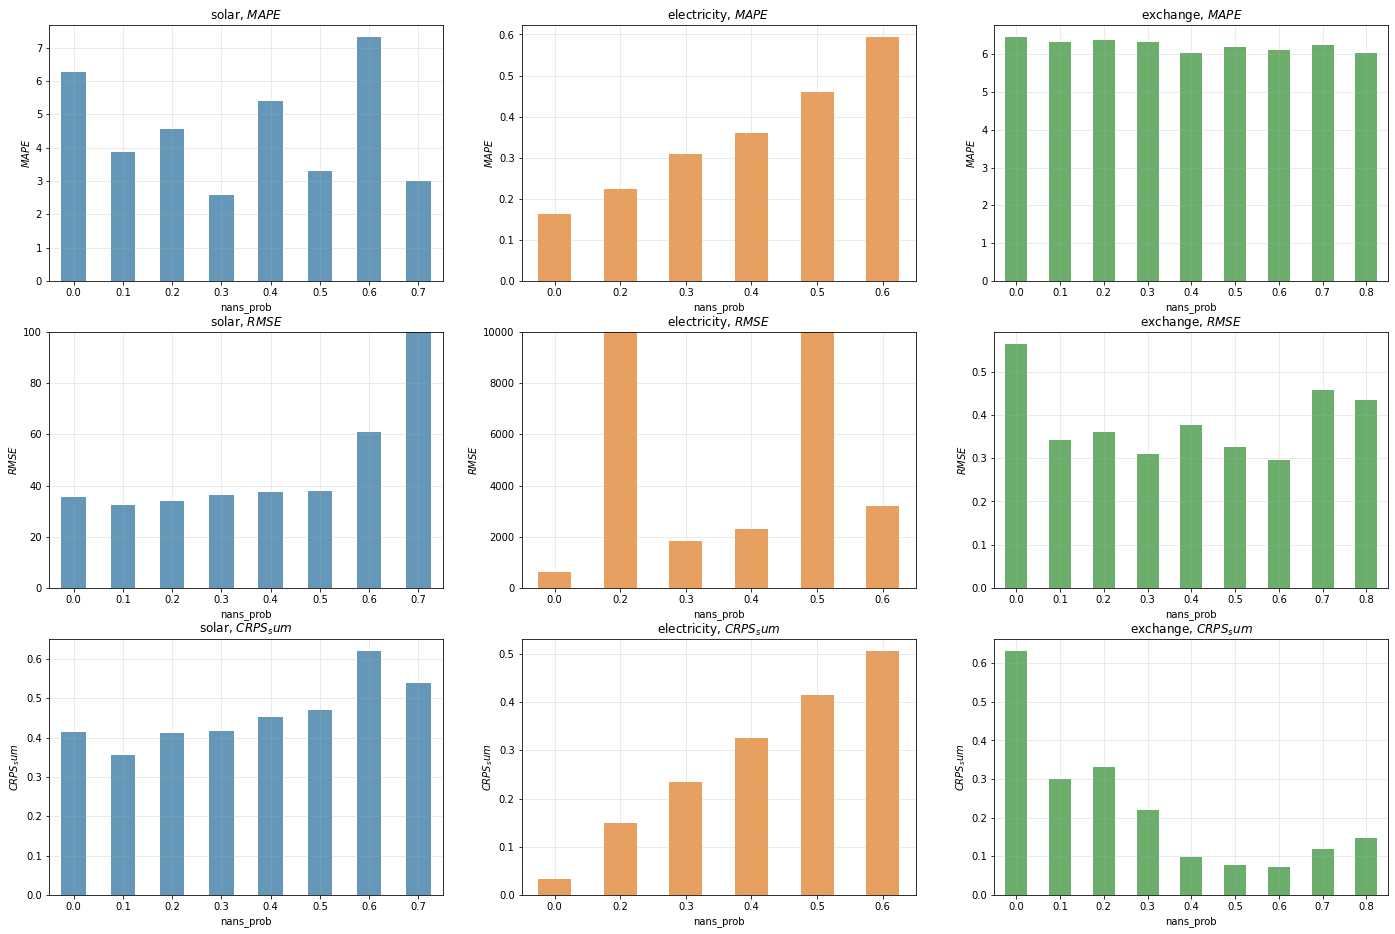

In [24]:
fig, ax = plt.subplots(3, 3, figsize=(24, 16))

for idx, metric in enumerate(all_metrics):
     
    df = all_metrics[metric]

    for (jdx, dataset), color in zip(enumerate(DATASETS), ['tab:blue', 'tab:orange', 'tab:green']):
        sns.barplot(
            data=df[df["dataset"] == dataset], 
            y="metric",
            x="nans_prob",
            alpha=0.75,
            ax=ax[idx][jdx], 
            width=0.5,
            color=color
        )

        if dataset == 'solar' and metric == 'RMSE':
            ax[idx][jdx].set_ylim((0, 100))
        if dataset == 'electricity' and metric == 'RMSE':
            ax[idx][jdx].set_ylim((0, 1e4))

        ax[idx][jdx].set_title(f"{dataset}, ${metric}$")
        ax[idx][jdx].grid(alpha=0.3)
        ax[idx][jdx].set_ylabel(f"${metric}$")

## Profiles

In [33]:
def dataset_summary(dataset, targets, forecasts):
    print(f"freq: {dataset.metadata.freq}")
    print(f"prediction length: {dataset.metadata.prediction_length}")
    print(f"n_components: {targets.shape[1]}\n")

    print(f"train start: {targets.index[0]}")
    print(f"train end: {targets.index[-1]}")
    print(f"length: {len(targets)}\n")

    print(f"test start: {forecasts.index[0]}")
    print(f"test end: {forecasts.index[-1]}")
    print(f"length: {len(forecasts)}")

In [34]:
def to_pandas(forecasts, freq):
    whole_test = []

    for i in range(len(forecasts)):

        forecast_length = forecasts[i].samples.shape[1]

        for idx, j in enumerate(forecasts[i].samples):

            dates = pd.date_range(forecasts[i].start_date.to_timestamp(), freq=freq, periods=forecast_length)

            df = pd.DataFrame(j, index=dates)

            df['sample'] = idx

            df[df < 0] = 0

            whole_test.append(df)

    whole_test = pd.concat(whole_test)

    return whole_test

In [35]:
# create dataframes

solar_forecasts = []
electricity_forecasts = []
exchange_forecasts = []

for nans_prob in np.linspace(0.0, 0.8, 9):
    nans_prob = np.round(nans_prob, 1)

    for dataset_name, dataset, df_storage in zip(DATASETS, [solar, electricity, exchange], [solar_forecasts, electricity_forecasts, exchange_forecasts]):
        
        try:
            cur_forecasts = forecasts['trans_maf'][dataset_name][nans_prob]['forecasts']
            
            cur_forecasts_df = to_pandas(forecasts=cur_forecasts, freq=dataset.metadata.freq)
            cur_forecasts_df['nans_prob'] = nans_prob


            df_storage.append(cur_forecasts_df)
        
        except:
            print(dataset_name, f"{nans_prob}", 'no_data')

solar_forecasts = pd.concat(solar_forecasts)
electricity_forecasts = pd.concat(electricity_forecasts)
exchange_forecasts = pd.concat(exchange_forecasts)

electricity 0.1 no_data
electricity 0.7 no_data
solar 0.8 no_data
electricity 0.8 no_data


In [36]:
def visualize_targets(targets: pd.DataFrame, name: str):
    targets.plot(figsize=(24, 4), linewidth=0.75)

    plt.grid(alpha=0.3)

    plt.title(f"{name} {targets.shape[1]} components [target].")

    plt.show()

### Solar

#### Dataset Summary

In [37]:
# targets
solar_targets = forecasts['trans_maf']['solar'][0.0]['targets']

# forecasts
solar_forecasts_maf = to_pandas(forecasts['trans_maf']['solar'][0.0]['forecasts'], freq=solar.metadata.freq)

# test length
solar_test_length = len(solar_forecasts_maf[solar_forecasts_maf['sample'] == 1])

# dataset summary
dataset_summary(solar, solar_targets[0], solar_forecasts_maf[solar_forecasts_maf['sample'] == 1])

freq: H
prediction length: 24
n_components: 137

train start: 2006-01-01 00:00
train end: 2006-10-21 00:00
length: 7033

test start: 2006-10-20 01:00:00
test end: 2006-10-27 00:00:00
length: 168


#### Train/test periods

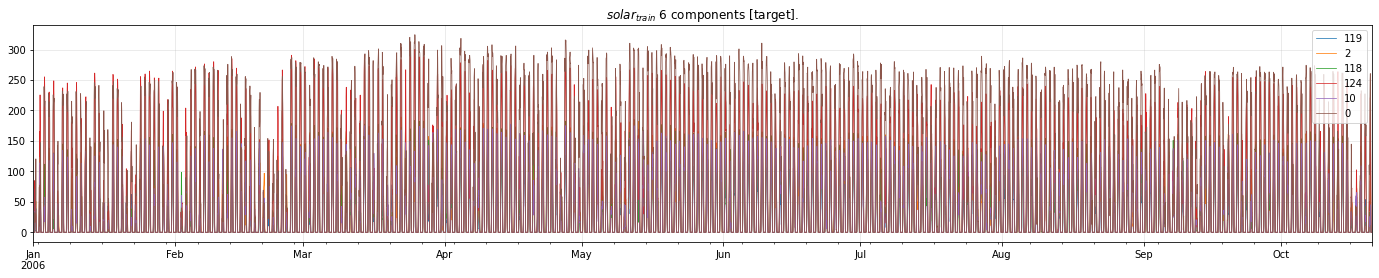

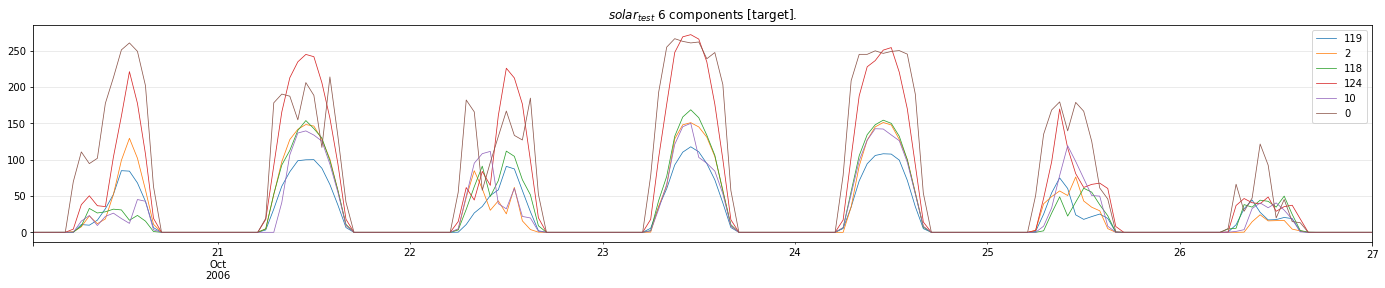

In [38]:
n = 6

solar_components = np.random.choice(range(solar_targets[0].shape[1]), size=n)

visualize_targets(solar_targets[0][solar_components], '$solar_{train}$')
visualize_targets(solar_targets[-1][solar_components].iloc[-solar_test_length:, :], '$solar_{test}$')

#### Actual/forecast visualisation

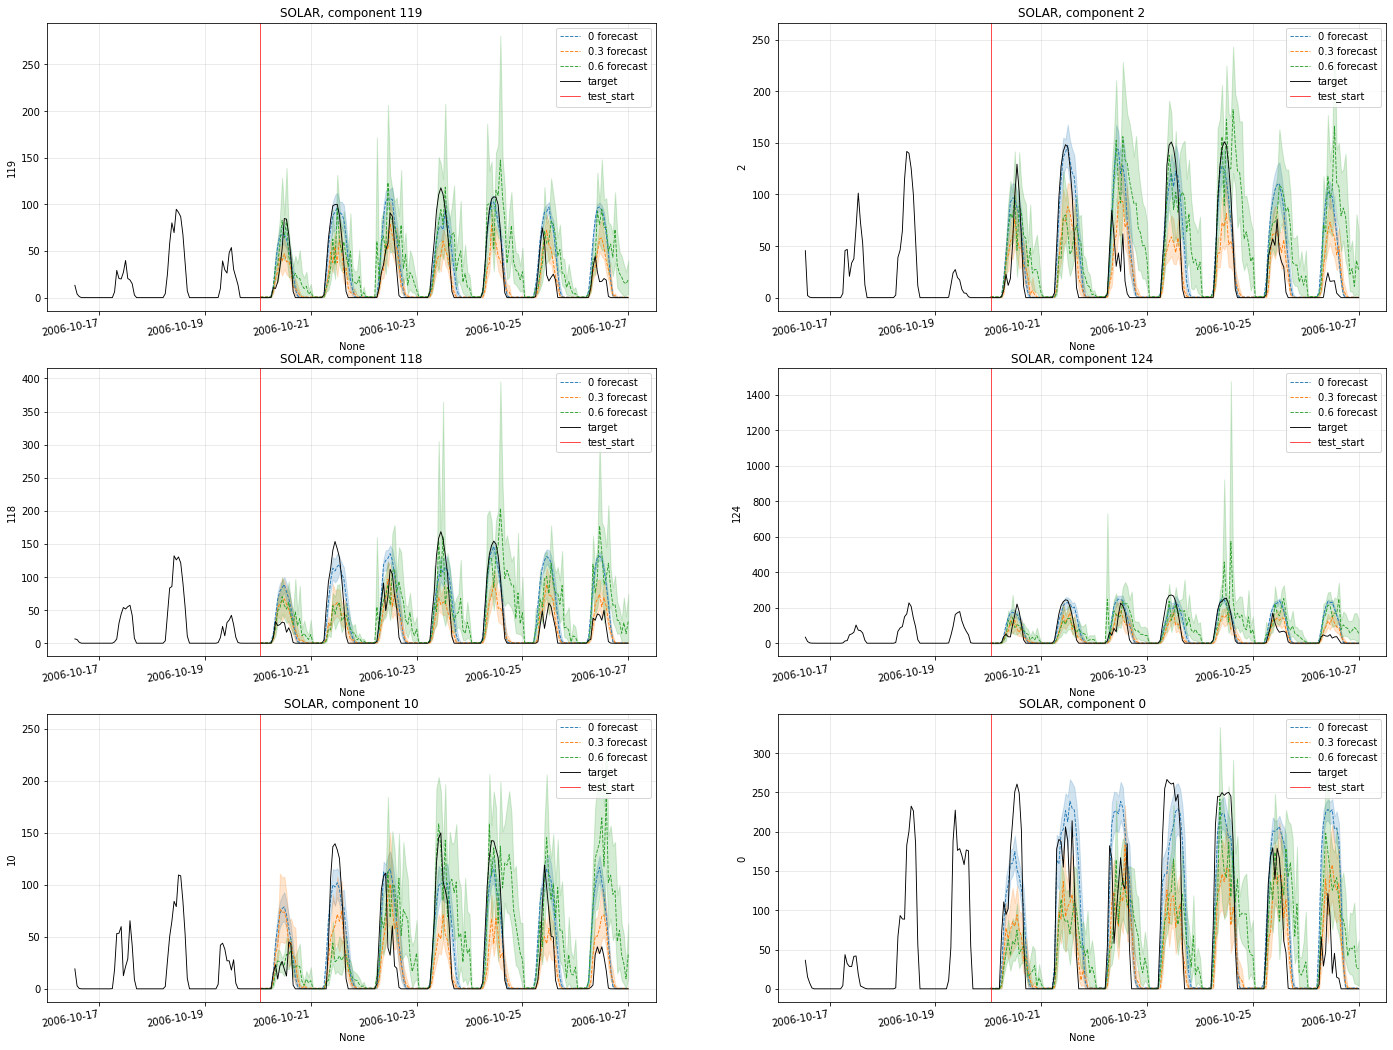

In [39]:
fig, ax = plt.subplots(3, 2, figsize=(24, 20))

axs = ax.flatten()

for idx, component in enumerate(solar_components):
    
    for nans_prob in [0, 0.3, 0.6]:
        nans_prob = np.round(nans_prob, 1)

        cur_forecasts = solar_forecasts[solar_forecasts['nans_prob'] == nans_prob]

        sns.lineplot(
            x=cur_forecasts.index,
            y=cur_forecasts[component],
            label=f"{nans_prob} forecast",
            linestyle='--', linewidth=0.9, ax=axs[idx]
        )

    solar_targets[-1][component][-int(solar_test_length*1.5):].plot(label='target', color='black', linewidth=0.9, ax=axs[idx])
    axs[idx].axvline(cur_forecasts.index[0], label='test_start', color='red', linewidth=0.7)


    axs[idx].legend()
    axs[idx].grid(alpha=0.3)
    axs[idx].set_title(f"SOLAR, component {component}")
    axs[idx].tick_params(axis='x', rotation=10)

### Electricity

In [40]:
# targets
electricity_targets = forecasts['trans_maf']['electricity'][0.0]['targets']

# forecasts
electricity_forecasts_maf = to_pandas(forecasts['trans_maf']['electricity'][0.0]['forecasts'], freq=electricity.metadata.freq)

# test length
el_test_length = len(electricity_forecasts_maf[electricity_forecasts_maf['sample'] == 1])

# dataset summary
dataset_summary(electricity, electricity_targets[0], electricity_forecasts_maf[electricity_forecasts_maf['sample'] == 1])

freq: H
prediction length: 24
n_components: 370

train start: 2014-03-19 09:00
train end: 2014-09-02 00:00
length: 4000

test start: 2014-09-01 01:00:00
test end: 2014-09-08 00:00:00
length: 168


#### Train/test periods

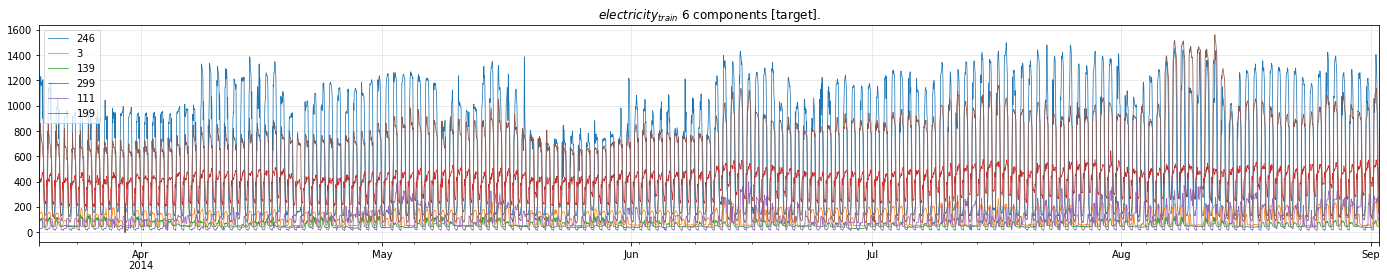

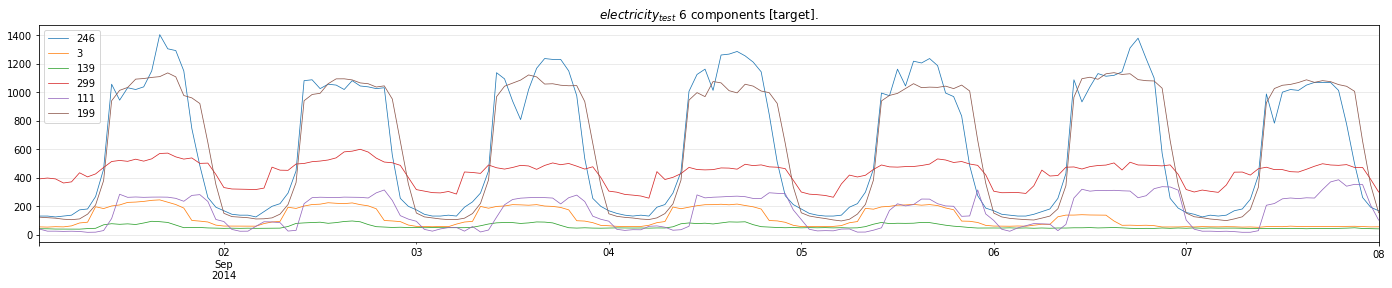

In [41]:
n = 6

electricity_components = np.random.choice(range(electricity_targets[0].shape[1]), size=n)

visualize_targets(electricity_targets[0][electricity_components], '$electricity_{train}$')
visualize_targets(electricity_targets[-1][electricity_components].iloc[-el_test_length:, :], '$electricity_{test}$')

#### Actual/forecast visualisation

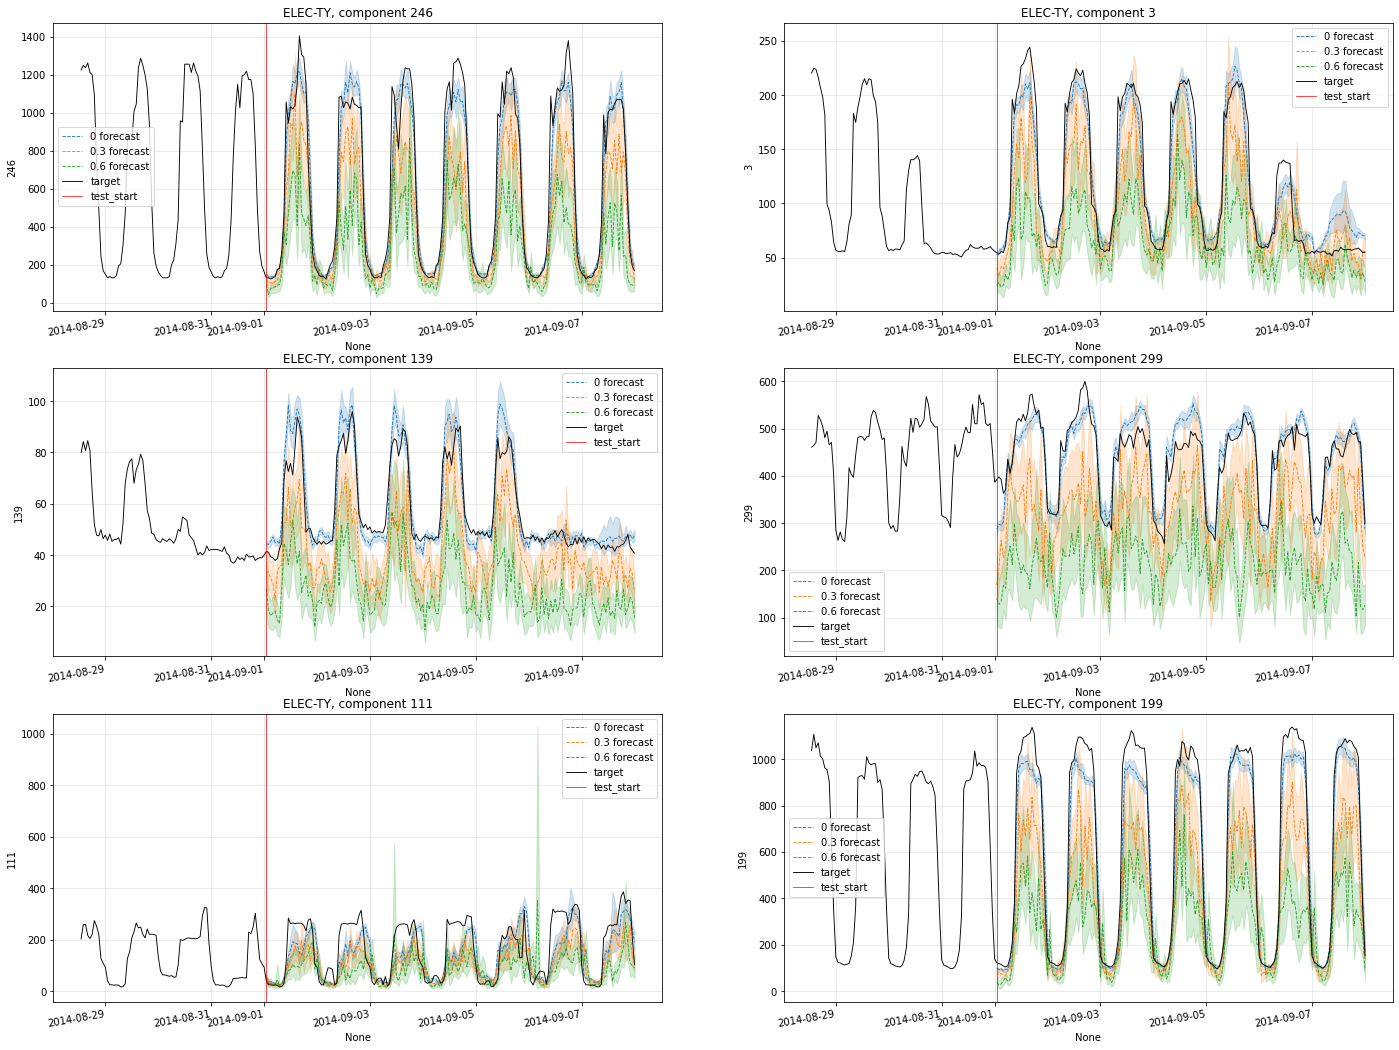

In [42]:
fig, ax = plt.subplots(3, 2, figsize=(24, 20))

axs = ax.flatten()

for idx, component in enumerate(electricity_components):
    
    for nans_prob in [0, 0.3, 0.6]:
        nans_prob = np.round(nans_prob, 1)

        cur_forecasts = electricity_forecasts[electricity_forecasts['nans_prob'] == nans_prob]

        sns.lineplot(
            x=cur_forecasts.index,
            y=cur_forecasts[component],
            label=f"{nans_prob} forecast",
            linestyle='--', linewidth=0.9, ax=axs[idx]
        )

    electricity_targets[-1][component][-int(el_test_length*1.5):].plot(label='target', color='black', linewidth=0.9, ax=axs[idx])
    axs[idx].axvline(cur_forecasts.index[0], label='test_start', color='red', linewidth=0.7)


    axs[idx].legend()
    axs[idx].grid(alpha=0.3)
    axs[idx].set_title(f"ELEC-TY, component {component}")
    axs[idx].tick_params(axis='x', rotation=10)

### Exchange

#### Actual/forecast visualisation

In [43]:
# targets
exchange_targets = forecasts['trans_maf']['exchange'][0.0]['targets']

# forecasts
exchange_forecasts_maf = to_pandas(forecasts['trans_maf']['exchange'][0.0]['forecasts'], freq=exchange.metadata.freq)

# test size
ex_test_size = len(exchange_forecasts_maf[exchange_forecasts_maf['sample'] == 1])

# dataset summary
dataset_summary(exchange, exchange_targets[0], exchange_forecasts_maf[exchange_forecasts_maf['sample'] == 1])

freq: 1B
prediction length: 30
n_components: 8

train start: 1990-01-01
train end: 2013-05-20
length: 6101

test start: 2013-04-09 00:00:00
test end: 2013-11-04 00:00:00
length: 150


#### Train/test periods

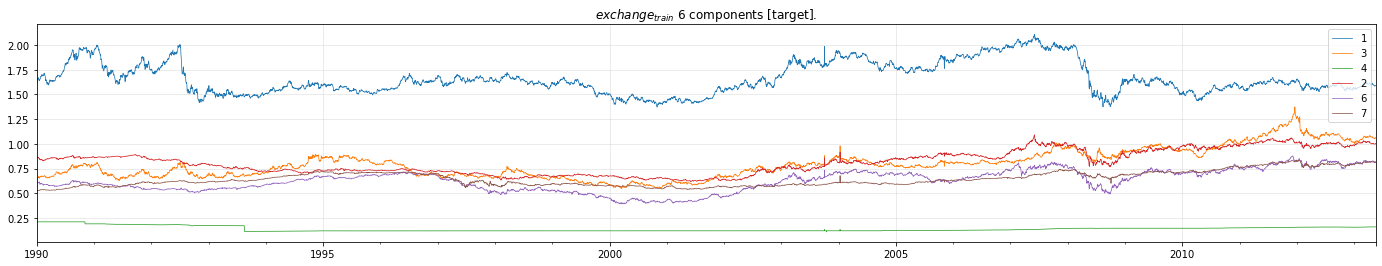

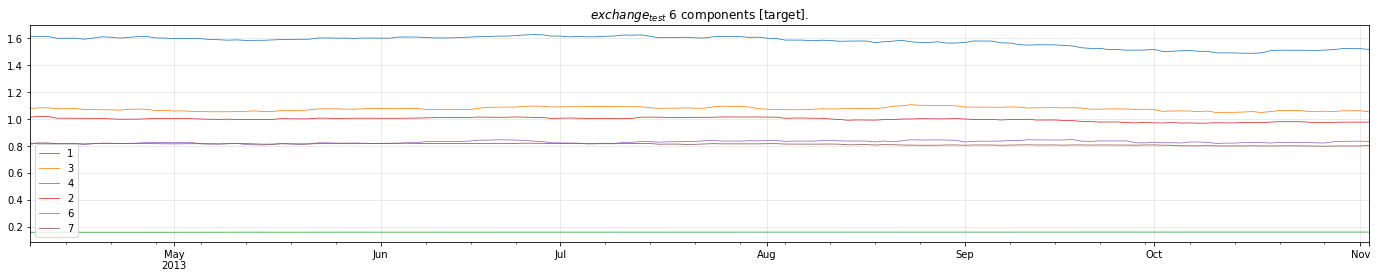

In [44]:
n = 6

exchange_components = np.random.choice(range(exchange_targets[0].shape[1]), size=n, replace=False)

visualize_targets(exchange_targets[0][exchange_components], '$exchange_{train}$')
visualize_targets(exchange_targets[-1][exchange_components].iloc[-ex_test_size:, :], '$exchange_{test}$')

#### Actual/forecast visualisation

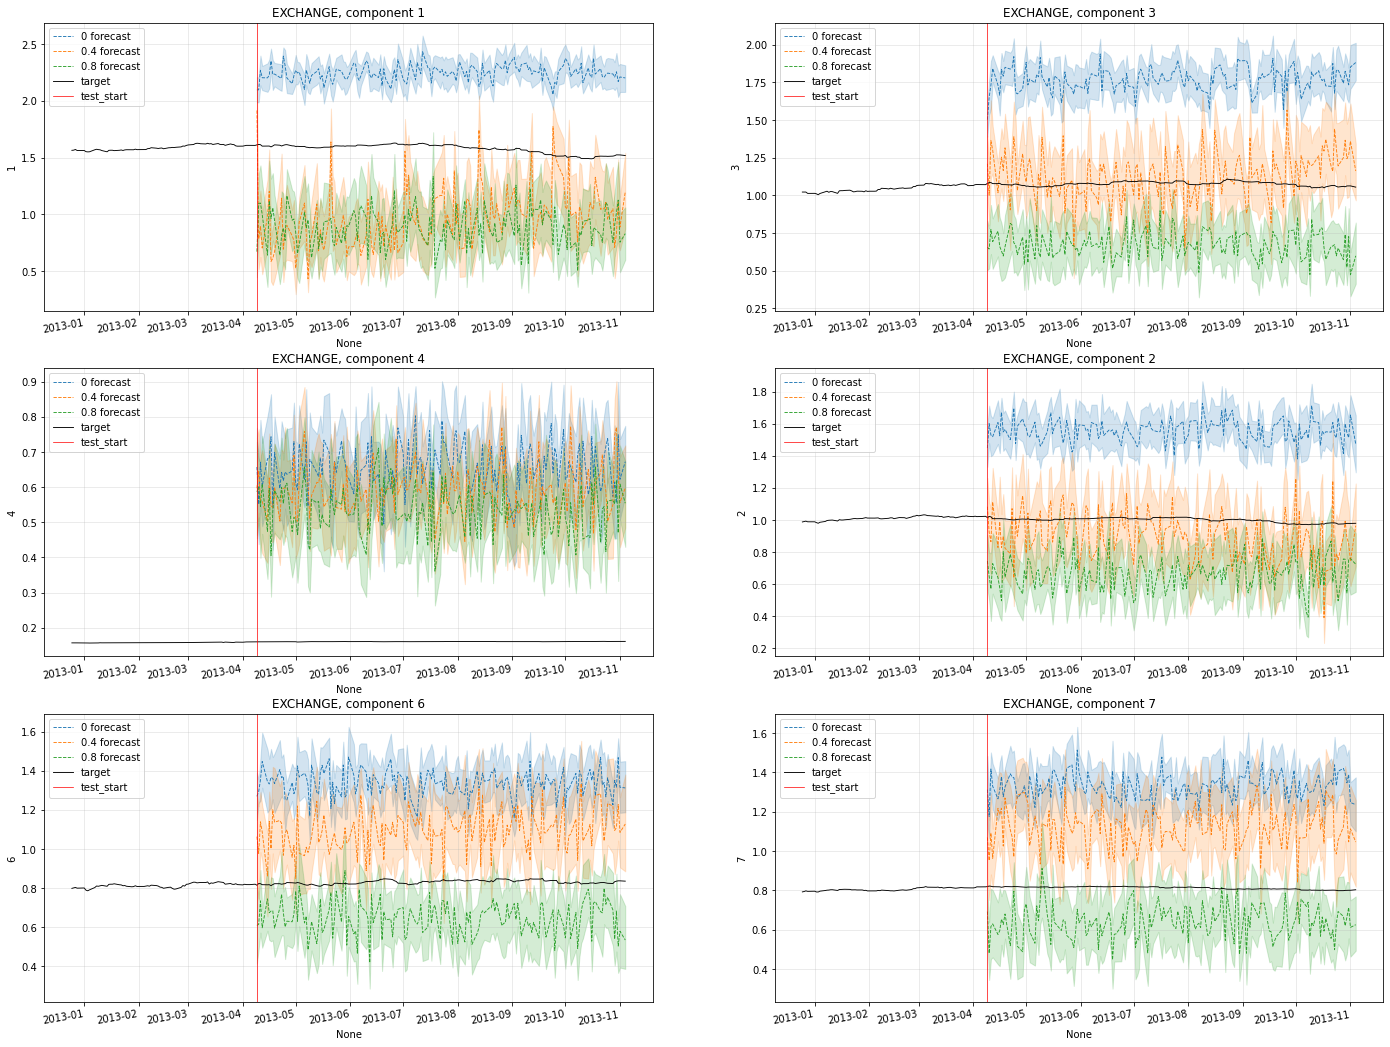

In [45]:
fig, ax = plt.subplots(3, 2, figsize=(24, 20))

axs = ax.flatten()

for idx, component in enumerate(exchange_components):
    
    for nans_prob in [0, 0.4, 0.8]:
        nans_prob = np.round(nans_prob, 1)

        cur_forecasts = exchange_forecasts[exchange_forecasts['nans_prob'] == nans_prob]

        sns.lineplot(
            x=cur_forecasts.index,
            y=cur_forecasts[component],
            label=f"{nans_prob} forecast",
            linestyle='--', linewidth=0.9, ax=axs[idx]
        )

    exchange_targets[-1][component][-int(ex_test_size*1.5):].plot(label='target', color='black', linewidth=0.9, ax=axs[idx])
    axs[idx].axvline(cur_forecasts.index[0], label='test_start', color='red', linewidth=0.7)


    axs[idx].legend()
    axs[idx].grid(alpha=0.3)
    axs[idx].set_title(f"EXCHANGE, component {component}")
    axs[idx].tick_params(axis='x', rotation=10)